# MNIST Fashion

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [8]:
x_train = pd.read_csv("Data/fashion-mnist_train.csv")
x_test = pd.read_csv("Data/fashion-mnist_test.csv")

In [9]:
x_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
x_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
y_train = x_train['label']
y_test = x_test['label']

# Drop 'label' column
x_train = x_train.drop(labels = ['label'],axis = 1) 
x_test = x_test.drop(labels = ['label'], axis = 1)



In [14]:
y_train.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Tenemos las piezas de ropa en train perfectamente distribuidas

In [29]:
def getImage(df, pos):
    pixels = df.loc[df.index == pos]
    pixels = np.array(pixels, dtype = 'uint8')
    pixels = pixels.reshape((28,28)) #Hay 784, su raiz cuadrada es 28 por tanto el tamaño de la dimension sera 28x28
    
    # Plot
    plt.title('Pice of clothing')
    plt.imshow(pixels, cmap='gray')
    #sns.heatmap(pixels)
    plt.show()

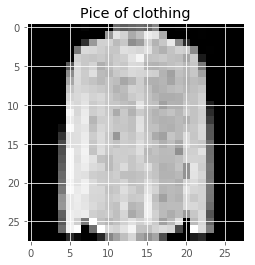

In [30]:
getImage(x_train, 2)

In [ ]:
#Buscamos valores nulos en test y train

In [43]:
def getNull (df):
    return df.isnull().any().describe()

In [44]:
print ('(Train)-Null Data: ' + str(getNull(x_train)) + '\n' +
       '(Test)-Null Data: ' + str(getNull(x_test)))

(Train)-Null Data: count       784
unique        1
top       False
freq        784
dtype: object
(Test)-Null Data: count       784
unique        1
top       False
freq        784
dtype: object


Hay el mismo numero de Nulls en train que en Test y ademas coincide con el numero de pixels por filas que a su vez es la dimension total, esto seguramente se deba a que la forma de marcar los bordes sean los valores nulos.

## Normalization

The CNN works better and faster on [0..1] data than on [0..255].

In [45]:
x_train = x_train/255
x_test = x_test/255

## Reshape

In [47]:
x_train.shape

(60000, 784)

In [49]:
x_test.shape

(10000, 784)

In [50]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(60000,28,28,1)
x_test = x_test.values.reshape(10000,28,28,1)

The original data is of type pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, in that case we would have reshaped 784px vectors to 28x28x3 3D matrices.

## One-Hot encoding

In [51]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

## Split training and validation set

In [53]:
# Set the random seed
random_seed = 12

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

| OriginalData | Split1 | Split2 | Split3 |
|-----------|------------|------------|-----------|
|   Train   | 
|           |
|    Test   |
|           |

## CNN - Model

In [56]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> [Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))